# TR-RB simulation

In [1]:
# ~~~
# This file is part of the paper:
#
#           "An adaptive projected Newton non-conforming dual approach
#         for trust-region reduced basis approximation of PDE-constrained
#                           parameter optimization"
#
#   https://github.com/TiKeil/Proj-Newton-NCD-corrected-TR-RB-for-pde-opt
#
# Copyright 2019-2020 all developers. All rights reserved.
# License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)
# Authors:
#   Luca Mechelli (2019 - 2020)
#   Tim Keil      (2019 - 2020)
# ~~~

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	q ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= (u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_d}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2 + \frac{\sigma_d}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}\\
j_{\mu}(u) & = -\sigma_d \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,u) &= \frac{\sigma_d}{2} \int_{D}^{} u^2 
\end{align}

The following code implements this particular case.

## prepare cells

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'
# domain of interest
bounding_box = [[0,0],[2,1]]
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition and tolerances

In [4]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,4,9], 'windows': [], 'doors': [6,7], 'heaters': [1,3,5,6,7,8,9]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,10], 'active_heaters': []}
summed_quantities = {'walls': [[1,2,3,7,8],[4,5,6]], 'windows': [], 'doors': [], 'heaters': [[1,2],[3,4],[9,10,11,12]]}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.025,0.1], iwc= [0.025,0.1], idc=[0.05,0.2], wc=[0.0005], ht=[0,100],
                                    owc_c=0.001,  iwc_c= 0.025,     idc_c=0.01,  wc_c=0.05,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = problem.parameter_space.sample_randomly(1, seed=10)[0]
mu_d = None

sigma_d = 100
weights = {'walls': 0.1, 'doors': 1, 'heaters': [0.002,0.002,0.0005,0.0005,0.0005,0.0005,0.004], 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy')

I am using the NCD corrected functional!!
my product is fixed_energy
mu_bar is: {doors: [0.1, 0.1], heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.049999999999999996, 0.049999999999999996, 0.049999999999999996]}


In [5]:
print('Information on the grid:')
print(data['grid'])

seed = 4                   # random seed for the starting value
radius = 0.1               # TR radius 
FOC_tolerance = 1e-7       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 60                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_SH = 800            # Maximum number of iteration for the TR Steihaug method
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)
iterative_solver = 'CG'    # chosen iterative solver

# parameter control
control_mu = False         # enable post processing for the optimal parameter estimation

# optional enrichment
tau_g = FOC_tolerance/sub_tolerance
tau_grad = 0.01
beta_3 = 1./2
minimum_radius = 1e-6
maximum_radius = 1e16

# some implementational variables
Qian_Grepl_subproblem = True
reductor_type = 'simple_coercive'

Information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


In [6]:
# starting with 
parameter_space = problem.parameter_space
mu = parameter_space.sample_randomly(1, seed=seed)[0]

### What methods do you want to test ?

In [7]:
optimization_methods = [
    # FOM Method
    'SH',   # Steihaug Version 4
    # Newton 
        # NCD-corrected
         'Method_4', # TR-RB (a)
         'Method_4_optional',
         'Method_5', # TR-RB (c)
         'Method_5_optional',
        # Aggregated
#          'Method_6', # TR-RB (b) 
#          'Method_7', # TR-RB (d)
    # BFGS
        # NCD-corrected from KMSOV'20
         'Method_8', # TR-RB
    # Qian Grepl method from QGVW'17
#          'Method_9'
]

#optimization_methods = ['All']

## Visualizations

Visualize diffusion and rhs

In [8]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu.copy()
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)

opt_fom.visualize(diff)

Output()

In [9]:
opt_fom.visualize(rhs)

Output()

In [10]:
opt_fom.visualize(doI)

Output()

We can easily solve the primal and dual equations by calling 

In [11]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)

Output()

In [12]:
opt_fom.visualize(p)

Output()

# Full Order Optimization

In [13]:
parameters = opt_fom.parameters
if mu_d is not None:
    mu_opt = mu_d
else:
    #use result from previous FOM run
    mu_opt = parameters.parse(np.array([5.000000000000e-02,  5.000000000000e-02,  2.238254711947e+01,
  2.339650455721e+01,  4.870348426512e+01,  4.937422778852e+01,
  5.236272251326e+01,  5.411556305764e+01,  2.352380079299e+01,
  2.500000000000e-02,  2.500000000000e-02,  2.500000000000e-02]))
    
mu_opt_as_array = mu_opt.to_numpy()
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', mu.to_numpy())
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [5.00000000e-02 5.00000000e-02 2.23825471e+01 2.33965046e+01
 4.87034843e+01 4.93742278e+01 5.23627225e+01 5.41155631e+01
 2.35238008e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02]
Optimal J:  5.813965062384796

Starting parameter:  [1.95054476e-01 1.32084837e-01 9.72684360e+01 7.14815994e+01
 6.97728825e+01 2.16089496e+01 9.76274455e+01 6.23025520e-01
 2.52982362e+01 5.76093649e-02 8.34537191e-02 3.98263806e-02]
Starting J:  318.30106091332254


In [14]:
print(mu_opt.parameters)

{doors: 2, heaters: 7, walls: 3}


# TR Steihaug

In [15]:
from pdeopt.TR import TR_Steihaug
from pdeopt.tools import compute_errors

TR_parameters = {'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'max_iterations': max_it_SH,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True,
                 'iterative_solver': iterative_solver}

if 'SH'  in optimization_methods or 'All' in optimization_methods:
    mus_SH, times_SH, Js_SH, FOC_SH = TR_Steihaug(opt_fom, problem.parameter_space, TR_parameters)
    times_full_SH, J_error_SH, mu_error_SH, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                                       mus_SH, Js_SH, times_SH, 0, FOC_SH)

Computing at first the Cauchy point
The model function admits a point that has all components on the boundary 
 Returning the direction to reach it to continue
Using CG-Steihaug for the linear system
Enlarging the radius to 0.2
k: 1 - Cost Functional: 307.92663357952824 - mu: {doors: [0.04999999999999999, 0.052043382261756976], heaters: [97.06843599648843, 71.28159936743646, 69.57288245972708, 21.408949558037637, 97.42744547762418, 0.4230255204589863, 25.098236238344395], walls: [0.025811762561705393, 0.02645512005177738, 0.02536908111269092]}
First order critical condition: 13.708664393384039
***********************************************

Computing at first the Cauchy point
The model function admits a point that has all components on the boundary 
 Returning the direction to reach it to continue
Using CG-Steihaug for the linear system
Enlarging the radius to 0.4
k: 2 - Cost Functional: 294.91419244928284 - mu: {doors: [0.05, 0.050098385836093225], heaters: [96.66843599648843, 70.881

Using CG-Steihaug for the linear system
k: 17 - Cost Functional: 5.813965206410785 - mu: {doors: [0.05, 0.05], heaters: [22.38503595523444, 23.399856646486, 48.70672890634799, 49.37268346715151, 52.35599833200893, 54.09940619919385, 23.526640593545114], walls: [0.025, 0.025, 0.025]}
First order critical condition: 0.00012297098788813476
***********************************************

Computing at first the Cauchy point
Using CG-Steihaug for the linear system
k: 18 - Cost Functional: 5.813965081614697 - mu: {doors: [0.05, 0.05], heaters: [22.383069959701157, 23.39716572411149, 48.7040722839011, 49.37406431114433, 52.36175142257641, 54.11311303921616, 23.52451777139847], walls: [0.025, 0.025, 0.025]}
First order critical condition: 0.00010437294237772448
***********************************************

Computing at first the Cauchy point
Using CG-Steihaug for the linear system
k: 19 - Cost Functional: 5.813965064891363 - mu: {doors: [0.05, 0.05], heaters: [22.382877928071967, 23.3969465

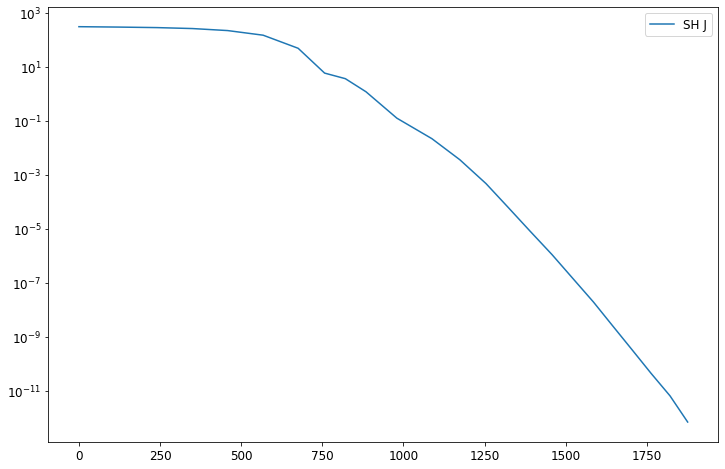

In [16]:
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH, label='SH J')
    plt.legend()

In [17]:
# compute the error in the target
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    if 'SH' in optimization_methods or 'All' in optimization_methods:
        empty_bi = EmptyBoundaryInfo(data['grid'])
        u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
        diff= u.to_numpy()-u_d.to_numpy()
        diff_= opt_fom.solution_space.from_numpy(diff)
        Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
        print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
        print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

5.954105497682962
[[0.15747103]]


# TR-RB approaches

In [18]:
import time
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor
from pdeopt.TR import TR_algorithm, TR_algorithm_with_optional_enrichment

from pymor.parameters.functionals import MinThetaParameterFunctional
ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

set_defaults({'pymor.operators.constructions.induced_norm.raise_negative': False})
set_defaults({'pymor.operators.constructions.induced_norm.tol': 1e-20})

## Newton Method

### NCD-corrected

#### Lagrange Basis (Method 4)

In [19]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_4' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver,
                 'JFE_start': J_start} # This is not cheating because the quantity to compute this are accessible when preparing pdeopt_reductor
                                       # so the computational time to compute this is already

    extension_params = {'Enlarge_radius': True, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_4, times_4, Js_4, FOC_4, data_4 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space,
                                                TR_parameters, extension_params)
    
    times_full_4_actual, J_error_4_actual, mu_error_4_actual, FOC_4_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_4, Js_4, times_4, tictoc, FOC_4)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.19505447585205155, 0.13208483737635834], heaters: [97.26843599648844, 71.48159936743646, 69.77288245972709, 21.608949558037637, 97.62744547762418, 0.6230255204589863, 25.298236238344394], walls: [0.05760936493033344, 0.08345371913453145, 0.03982638059501899]}
Starting value of the cost: 318.30106083650935
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
boundary criterium of the TR satisfied, so stopping the sub-problem [0.09716996] 11.646362699211734
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
k: 0 - j 1 - Cost Functional: 223.64419391956721 - mu: {doors: [0.05, 0.05], heaters: [94.6412502461567, 68.77008681835096, 68.384494594058

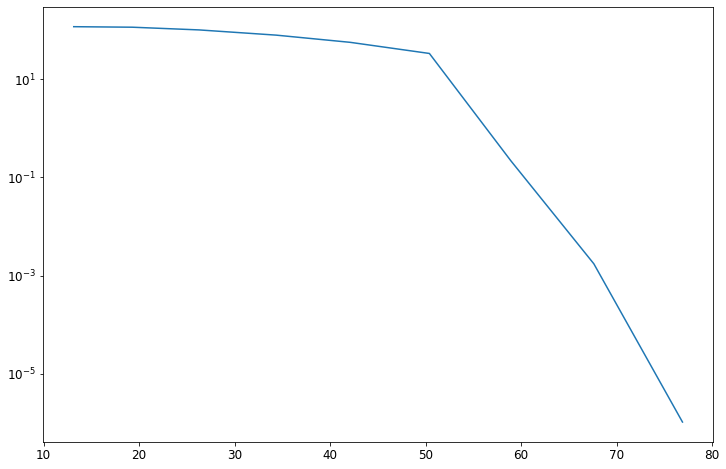

In [20]:
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual)

#### Lagrange Basis with optional enrichment (Method 4.a)

In [21]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver,
                 'tau_g': tau_g, 'tau_grad': tau_grad, 'beta_3': beta_3,
                 'minimum_radius': minimum_radius, 'maximum_radius': maximum_radius, 
                 'JFE_start': J_start}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_4bis, times_4bis, Js_4bis, FOC_4bis, data_4bis = TR_algorithm_with_optional_enrichment(opt_rom, pdeopt_reductor, parameter_space,
                                                TR_parameters, extension_params)
    
    times_full_4bis_actual, J_error_4bis_actual, mu_error_4bis_actual, FOC_4bis_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_4bis, Js_4bis, times_4bis, tictoc, FOC_4bis)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.19505447585205155, 0.13208483737635834], heaters: [97.26843599648844, 71.48159936743646, 69.77288245972709, 21.608949558037637, 97.62744547762418, 0.6230255204589863, 25.298236238344394], walls: [0.05760936493033344, 0.08345371913453145, 0.03982638059501899]}
Starting value of the cost: 318.30106083650935
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
boundary criterium of the TR satisfied, so stopping the sub-problem [0.09716996] 11.646362699211734
Sufficient decrease condition fulfilled
Enriching the RB model
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
enlarging the TR radius to 0.2
k: 0 - j 1 - Cost Functional: 223.64419398300606 - mu: {doors: [0.05, 0.05], heaters: [94.64125024

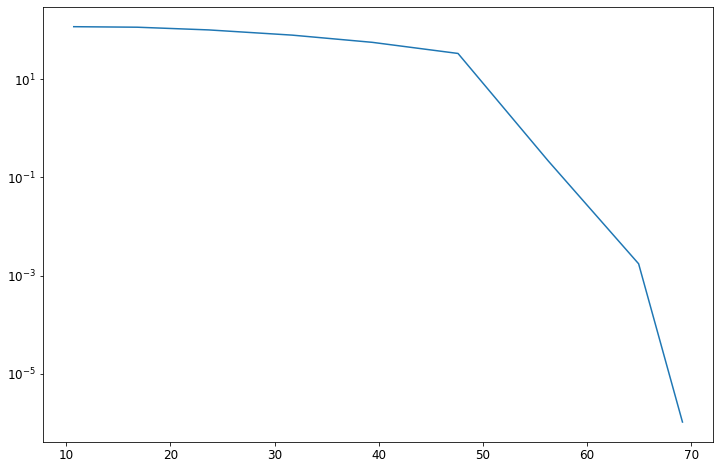

In [22]:
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual)

#### Directional Taylor Basis (Method 5)

In [23]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_5' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'AdaptiveTaylor_Newton',  'iterative_solver': iterative_solver,
                 'JFE_start': J_start}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_5, times_5, Js_5, FOC_5, data_5 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_5_actual, J_error_5_actual, mu_error_5_actual, FOC_5_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_5, Js_5, times_5, tictoc, FOC_5)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.19505447585205155, 0.13208483737635834], heaters: [97.26843599648844, 71.48159936743646, 69.77288245972709, 21.608949558037637, 97.62744547762418, 0.6230255204589863, 25.298236238344394], walls: [0.05760936493033344, 0.08345371913453145, 0.03982638059501899]}
Starting value of the cost: 318.30106083650935
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
boundary criterium of the TR satisfied, so stopping the sub-problem [0.09716996] 11.646362699211734
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Length of Bases are 3 and 3
k: 0 - j 1 - Cost Functional: 223.6441939195679 - mu: {doors: [0.05, 0.05], heaters: [94.6412502461567, 68.77008681835096, 68.38449459405882, 20.21427238955573, 96

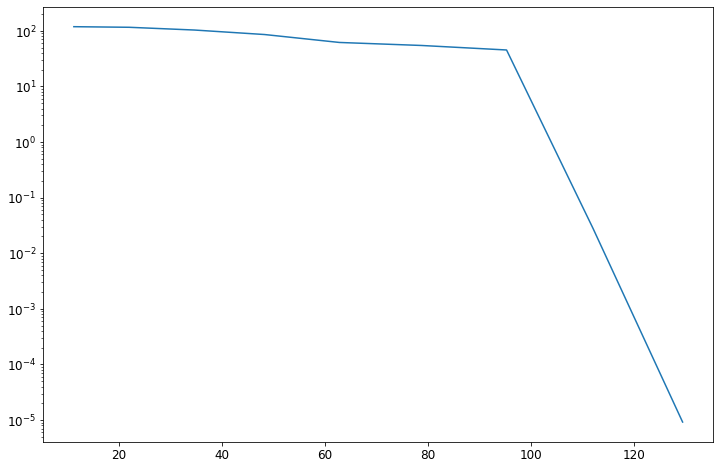

In [24]:
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual)

#### Directional Taylor Basis with optional enrichment (Method 5.a)

In [25]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu,  'iterative_solver': iterative_solver,
                 'tau_g': tau_g, 'tau_grad': tau_grad, 'beta_3': beta_3,
                 'minimum_radius': minimum_radius, 'maximum_radius': maximum_radius, 
                 'opt_method': 'AdaptiveTaylor_Newton',  
                 'JFE_start': J_start} 

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_5bis, times_5bis, Js_5bis, FOC_5bis, data_5bis = TR_algorithm_with_optional_enrichment(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_5bis_actual, J_error_5bis_actual, mu_error_5bis_actual, FOC_5bis_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_5bis, Js_5bis, times_5bis, tictoc, FOC_5bis)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.19505447585205155, 0.13208483737635834], heaters: [97.26843599648844, 71.48159936743646, 69.77288245972709, 21.608949558037637, 97.62744547762418, 0.6230255204589863, 25.298236238344394], walls: [0.05760936493033344, 0.08345371913453145, 0.03982638059501899]}
Starting value of the cost: 318.30106083650935
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
boundary criterium of the TR satisfied, so stopping the sub-problem [0.09716996] 11.646362699211734
Sufficient decrease condition fulfilled
Enriching the RB model
building simple coercive dual reductor...
Length of Bases are 3 and 3
enlarging the TR radius to 0.2
k: 0 - j 1 - Cost Functional: 223.64419398300606 - mu: {doors: [0.05, 0.05], heaters: [94.6412502461567, 68.77008681835096

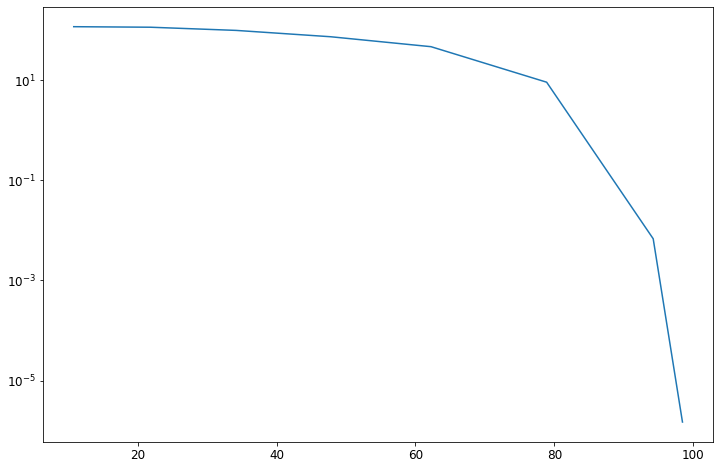

In [26]:
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual)

### Aggregated

#### excluding directional sensitivities (Method 6) -- (b)

In [27]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)

if 'Method_6' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                unique_basis=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_6, times_6, Js_6, FOC_6, data_6 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_6_actual, J_error_6_actual, mu_error_6_actual, FOC_6_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_6, Js_6, times_6, tictoc, FOC_6)

In [28]:
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, mu_error_6_actual)

#### including directional sensitivities (Method 7) -- (d)

In [29]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)

if 'Method_7' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                unique_basis=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'estimate_tolerance': estimate_tolerance, 
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'AdaptiveTaylor_Newton',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_7, times_7, Js_7, FOC_7, data_7 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_7_actual, J_error_7_actual, mu_error_7_actual, FOC_7_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_7, Js_7, times_7, tictoc, FOC_7)

In [30]:
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual)

## NCD corrected BFGS Method (KMSOV'20)

In [31]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_8' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8, times_8, Js_8, FOC_8, data_8 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_8_actual, J_error_8_actual, mu_error_8_actual, FOC_8_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8, Js_8, times_8, tictoc, FOC_8)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.19505447585205155, 0.13208483737635834], heaters: [97.26843599648844, 71.48159936743646, 69.77288245972709, 21.608949558037637, 97.62744547762418, 0.6230255204589863, 25.298236238344394], walls: [0.05760936493033344, 0.08345371913453145, 0.03982638059501899]}
Starting value of the cost: 318.30106083650935
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
k: 0 - j 1 - Cost Functional: 223.64419391956721 - mu: {doors: [0.05, 0.05], heaters: [94.6412502461567, 68.77008681835096, 68.38449459405882, 20.21427238955573, 96.1

k: 10 - j 236 - Cost Functional: 5.979778155415584 - mu: {doors: [0.05, 0.12245359330182091], heaters: [23.813031898224118, 25.74525515718261, 54.8152134615038, 39.68252764508658, 66.4237275658045, 40.66303653057998, 22.124190454120964], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 0.1402958094713956
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
relative differences mu 3.623670506273891e-05 and J 2.5612043637467667e-08
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 13 and 13
k: 11 - j 400 - Cost Functional: 5.81396620377649 - mu: {doors: [0.05, 0.05], heaters: [22.390405812288794, 23.383708922748202, 48.74634745798104, 49.381895793817286, 52.32263055449605, 54.1243135149137, 23.52245479983742], walls: [0.025, 0.025, 0.025]}
computing the fom g

Subproblem converged: FOC = 2.745026083277951e-07, mu_diff = 2.395720361632753e-15, J_diff = 0.0 
relative differences mu 2.395720361632753e-15 and J 0.0
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 23
k: 21 - j 1 - Cost Functional: 5.813965062928064 - mu: {doors: [0.05, 0.05], heaters: [22.382573919906065, 23.396534969667194, 48.7032991801553, 49.37398451598215, 52.36288542167845, 54.11578695843148, 23.52377372018237], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.750803390979502e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 2.7450597915489036e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to check the sufficient

building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 24
k: 31 - j 1 - Cost Functional: 5.813965062926622 - mu: {doors: [0.05, 0.05], heaters: [22.382573919906065, 23.396534969667194, 48.7032991801553, 49.37398451598215, 52.36288542167845, 54.11578695843148, 23.52377372018237], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.750803390979502e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 2.7450765448987415e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 24
k: 32 - j 1 - Cost Functional: 5.813965062926622 - mu: {doors: [0.05, 0.05], heaters: [22.3

k: 41 - j 1 - Cost Functional: 5.813965062926854 - mu: {doors: [0.05, 0.05], heaters: [22.382573919906065, 23.396534969667194, 48.7032991801553, 49.37398451598215, 52.36288542167845, 54.11578695843148, 23.52377372018237], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.750803390979502e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 2.74507386721273e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 25
k: 42 - j 1 - Cost Functional: 5.813965062926854 - mu: {doors: [0.05, 0.05], heaters: [22.382573919906065, 23.396534969667194, 48.7032991801553, 49.37398451598215, 52.36288542167845, 54.115

Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 2.7450048372281724e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 26
k: 52 - j 1 - Cost Functional: 5.813965062932834 - mu: {doors: [0.05, 0.05], heaters: [22.382573919906065, 23.396534969667194, 48.7032991801553, 49.37398451598215, 52.36288542167845, 54.11578695843148, 23.52377372018237], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.750803390979502e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 2.7450048372281724e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to 

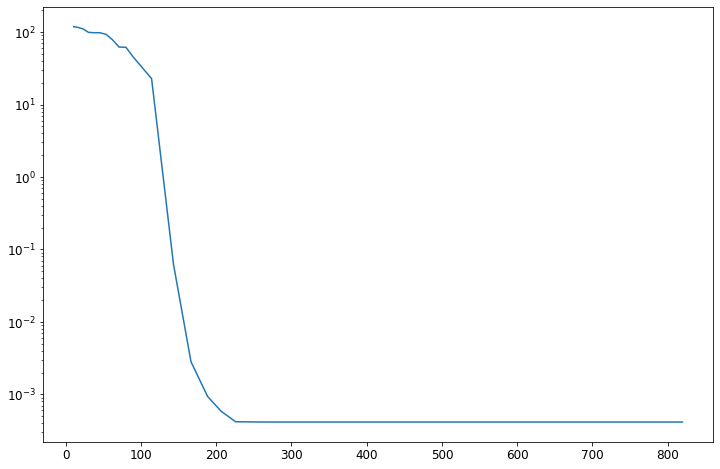

In [32]:
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual)

## Qian-Grepl-Method

In [33]:
#Qian-Grepl

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]

if 'Method_9' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                                RBbasis, dual_RBbasis, 
                                                                opt_product=opt_fom.opt_product, 
                                                                prepare_for_hessian=False,
                                                                prepare_for_gradient_estimate=True,
                                                                coercivity_estimator=ce, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()
    tictoc = time.time() - tic
    
    TR_parameters = {'Qian-Grepl': True,
                 'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_9, times_9, Js_9, FOC_9, data_9 = TR_algorithm(
        opt_rom, pdeopt_reductor, parameter_space, TR_parameters, extension_params)

    times_full_9_actual, J_error_9_actual, FOC_9_actual, mu_error_9_actual = compute_actual_errors(
        opt_fom, parameter_space, J_start, J_opt, mus_9, times_9, tictoc, mu, mu_opt_as_array)
    

In [34]:
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual)

# Results

In [35]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

{doors: [0.05, 0.05], heaters: [22.38254711947, 23.39650455721, 48.70348426512, 49.37422778852, 52.36272251326, 54.11556305764, 23.52380079299], walls: [0.025, 0.025, 0.025]}


Output()

## Plot results

### J error

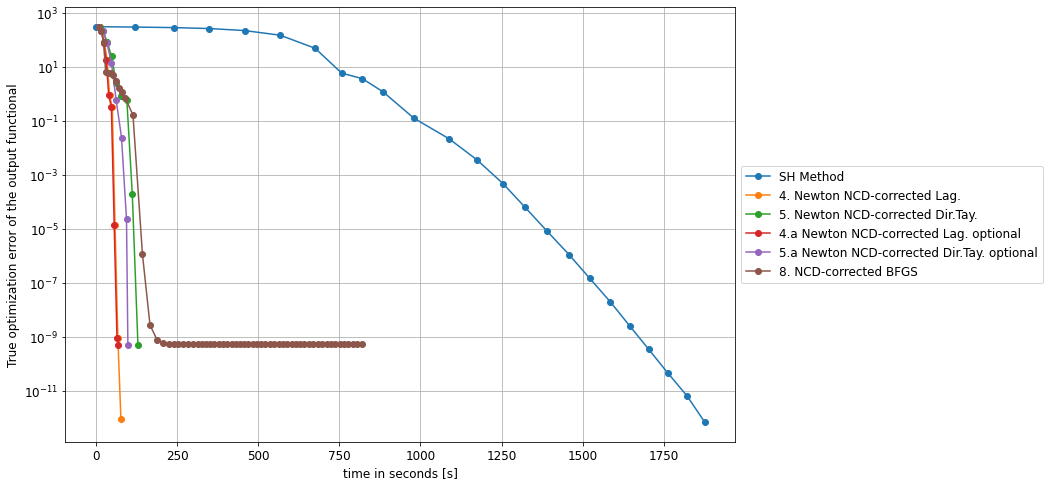

In [36]:
timings_figure = plt.figure()
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,J_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,J_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,J_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag. optional')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,J_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay. optional')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,J_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,J_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,J_error_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot FOC

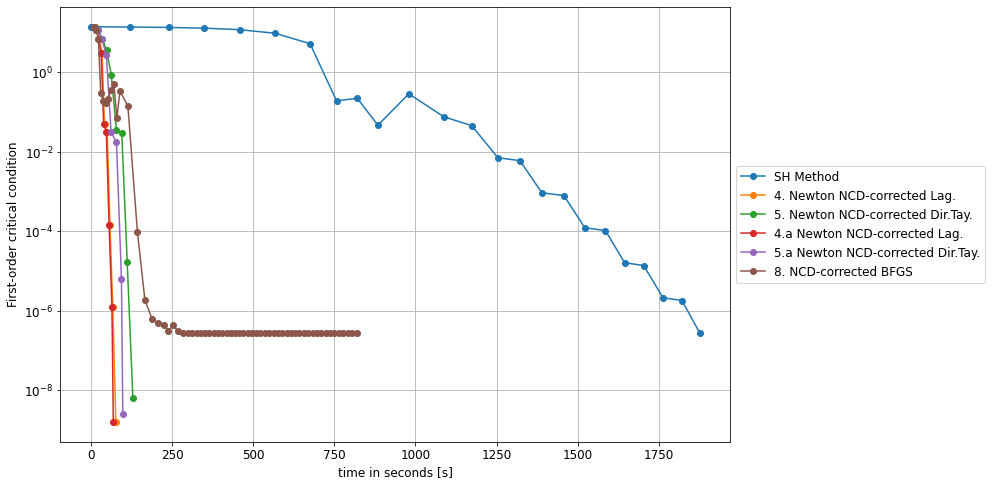

In [37]:
timings_figure = plt.figure()

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH, FOC_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual, FOC_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual, FOC_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual, FOC_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual, FOC_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, FOC_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual, FOC_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual, FOC_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual, FOC_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot Mu error

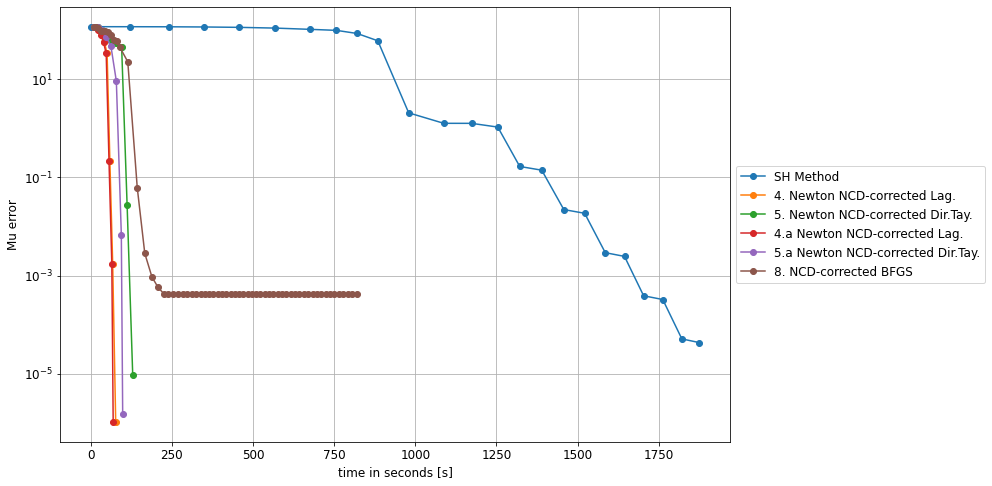

In [38]:
if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,mu_error_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,mu_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,mu_error_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('Mu error')
#plt.xlim([-1,100])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Save the data

In [39]:
#save data
from pdeopt.tools import save_data

directory = f'results/Starter{seed}'

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_SH, J_error_SH, 1, mu_error=mu_error_SH, FOC=FOC_SH)
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4_actual, J_error_4_actual, 4, mu_error=mu_error_4_actual, FOC=FOC_4_actual, additional_data=data_4)
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5_actual, J_error_5_actual, 5, mu_error=mu_error_5_actual, FOC=FOC_5_actual, additional_data=data_5)
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4bis_actual, J_error_4bis_actual, 2, mu_error=mu_error_4bis_actual, FOC=FOC_4bis_actual, additional_data=data_4bis)
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5bis_actual, J_error_5bis_actual, 3, mu_error=mu_error_5bis_actual, FOC=FOC_5bis_actual, additional_data=data_5bis)
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_6_actual, J_error_6_actual, 6, mu_error=mu_error_6_actual, FOC=FOC_6_actual, additional_data=data_6)
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_7_actual, J_error_7_actual, 7, mu_error=mu_error_7_actual, FOC=FOC_7_actual, additional_data=data_7)
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_actual, J_error_8_actual, 8, mu_error=mu_error_8_actual, FOC=FOC_8_actual, additional_data=data_8)
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_9_actual, J_error_9_actual, 9, mu_error=mu_error_9_actual, FOC=FOC_9_actual, additional_data=data_9)    